# LSTM- Training custom model:

Text generation is the task of producing new text from a given input prompt. An example of text generation using machine learning is `GitHub’s Copilot`, which can generate code. Apart from code generation, text generation models can:

1. Generate stories, for example, try passing “Once upon a time " as input to a GPT-2 model.
2. Generate poetry.
3. Complete a paragraph with missing sentences. 
4. Summarize an article.
5. Answer questions given some context.

And many more...

In this notebook, we develop a custom LSTM for the task of story generation. We do so by training a causal language model.  A causal language model tries to predict the next token in a given input sequence. In this way, it builds an understanding of the data it is trained on. 

__Agenda__:

1. Load the dataset from csv files
2. Tokenize and preprocess text
3. Create Batches
4. Train custom LSTM model 
5. Evaluate trained model





## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/My Drive/nlp

/content/gdrive/My Drive/nlp


In [ ]:
!ls

ai-story_gen  models			 story_gpt2
data	      story_distilgpt2_finetune  story_gpt2_finetune


## Parameters for notebook execution:

It's better to store all the parameters we need for a successful execution in one place. This way it's easy to manage the parameters. 

In [ ]:
import os 

# current directory path
DIR_PATH=os.getcwd()

In [ ]:
DIR_PATH

'/content/gdrive/My Drive/nlp'

In [ ]:
# parameters

# SAMPLE
TRAIN_ROWS=50000
TEST_ROWS=5000

# PATH OF CSV FILES
TRAIN_PATH= DIR_PATH+"/data/train_df.csv"
VALID_PATH=DIR_PATH+"/data/valid_df.csv"
TEST_PATH= DIR_PATH+"/data/test_df.csv"

# DATA PROCESSING
CONTEXT_LEN=256

# HYPERPARAMETERS
TRAIN_BS= 64
TEST_BS= 64 
EPOCHS=3

## Load the data

In [ ]:
# import required libraries
from fastai.text.all import *
import pandas as pd

First, let's load the dataframes

In [ ]:
# load the data
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
valid_df = pd.read_csv(VALID_PATH)

Let's drop the unecessary columns:
- `Unnamed: 0`
- `prompts`


In [ ]:
train_df.drop(columns=['Unnamed: 0', 'prompts'], inplace=True)
test_df.drop(columns=['Unnamed: 0', 'prompts'], inplace=True)
valid_df.drop(columns=['Unnamed: 0', 'prompts'], inplace=True)

Selecting a subset of the data

In [ ]:
train_df = train_df.sample(n=TRAIN_ROWS, random_state=42)
valid_df = valid_df.sample(n=TEST_ROWS, random_state=42)

# test_df = test_df[:600]

`Fastai` requires us to tell it whether the data is coming from the training set or the testing set. So, we need to create a `is_valid` column which tells us whether the row represents data from the training set or the validation set. 

In [ ]:
train_df['is_valid']=False
valid_df['is_valid']=True

In [ ]:
valid_df.head(3)

,stories,is_valid
4462,"*Energy core online . Initializing start-up sequence . Optic sensors online . * <newline> <newline> Light . It always started with light . And then ... <newline> <newline> *Activating motor function . Radar online . Weapons system online . Downloading combat data . Prepare for war . * <newline> <newline> And then chaos . I stepped away from my constraints , eyes already searching the battlefield for enemy Spectres- mass produced , dumb AI whose only purpose was to destroy the plastic bodies of the enemy- gun at the ready . As the battle went on , one side would push toward the enemy , unti...",True
8719,"Esar flicked his tail nervously as he prepared to walk onstage . After years in the field , working in the frigid cold of the lower continent and the scorching heat of deserts he was finally ready to report his findings to the world . Esar had spoken before massive crowds before , but this time was different , this time he would be changing his people 's entire view of the world . <newline> Then the clipboard wielding assistant motioned for him to go on , Esar gulped , then walked forward . <newline> `` Ladies and gentlemen ! '' He proclaimed to the audience . `` Today I am here to announc...",True
9380,"Everyone sat silently in the darkened living room . The only sound that permeated through the darkness was the ticking of Mom 's old grandfather clock in the other room . Chris lost track of time after a few minutes . Or was it a few hours ? The clock dinged without warning . He counted eleven dings before it went back to it 's usual ticking . <newline> <newline> It is 11 P.M. and Dad will be getting home shortly . That 's the time he usually gets home , anyway , because that 's when he swings by the liquor stores right before they close . <newline> <newline> `` Thank you , everyone , for ...",True


Ok!!! Now, let's concatenate these two dataframes. 

In [ ]:
all_df = pd.concat([train_df, valid_df],ignore_index=True)

In [ ]:
all_df.sample(n=4)

,stories,is_valid
21039,"They came at night . The silent ones . The humans do not see them , but we do . Stories say humans were the ones who created them . Created us . Stories say the humans can feel both of us , with tiny hairs that alert them . But they never seem to , not fully . <newline> <newline> There 's a war being fought . A brutal slaughter as they come to take the children of man . We wait in closets and under beds . We sharpen our claws and teeth , strengthen our muscles and let out our breathes . The children hear us , and they hide under covers . It is as we plan . <newline> <newline> When they com...",False
4281,"To an outsider the Cannery would appear as any other faceless structure . With its massive form towering into the sky , sharing the same sickly concrete-grey color as the clouds who hugged the upper most levels . But to the prison guards that worked there , who had earned the conventional nickname of Crucifiers , it was a different place entirely . <newline> <newline> Michael stood at the two door wide entrance with an anxious smile on his face , unprepared for what would come . The doors buzzed and the lock clicked open . Michael sighed briefly before opening the right hand door . What he...",False
51676,"`` And I-uh-I will all-ways love yooo-ooo-ooo ! '' I belt out , then pause to strike a pose as the thrilling , albeit low-quality notes continue bravely on through the overhead speaker . <newline> <newline> `` Sharon , report to customer service . Customer waiting , '' rudely cuts off the rest of Whitney 's ( muted ) boisterous tones . <newline> <newline> I frown , and try to remember what I was doing on this aisle , before grabbing a random shelf item to sing into . I appear to be in the Clearance section . I am still holding my makeshift microphone . <newline> <newline> `` What the - '' ...",True
9977,"`` All in . '' <newline> The table went silent . No one went all in pre-flop , especially when they held less Time than everyone else . Ryan was playing a dangerous game . Fold , fold , fold . Things were looking up for Ryan with three players left to call . Six thousand minutes . The final three had that easily , looking at their forehead the digits were in the hundreds of thousands , even the millions . Ryan was staring directly at the player to call , willing him to play the hand . Fold . His eyes darted to the next , sending the same message . Call . Ryan flinched slightly but regained...",False


## Creating DataBlock and dataloaders:

In the last section, we loaded the data. Now, in this section, we will create the `DataBlock` and `Dataloaders` for the text data. 

In [ ]:
dsets= DataBlock(blocks=TextBlock.from_df('stories',min_freq=3,is_lm=True),
                    get_x=ColReader('text'),
                    splitter=ColSplitter())

In [ ]:
dls = dsets.dataloaders(source=all_df,bs=TRAIN_BS,seq_len=CONTEXT_LEN)

Let's see some examples from the dataloader. 

In [ ]:
dls.show_batch(max_n=5)

,text,text_
0,"xxbos xxmaj you know how the saying goes - you work hard . xxmaj you play hard . < newline > < newline > xxmaj the bets we made were n't just for fun , they were hardcore entertainment . xxmaj we needed these , an outlet for those mentally insane as us to keep us occupied and away from the money - hungry craze we were all too guilty of . < newline > < newline > ` ` 5 months boss . '' < newline > < newline > ` ` … xxmaj what ? '' < newline > < newline > ` ` xxmaj you heard me . 5 months . i want you to wreck the community and build it up again . xxmaj ground up . '' < newline > < newline > ` ` xxmaj listen , are you trying to make fun of","xxmaj you know how the saying goes - you work hard . xxmaj you play hard . < newline > < newline > xxmaj the bets we made were n't just for fun , they were hardcore entertainment . xxmaj we needed these , an outlet for those mentally insane as us to keep us occupied and away from the money - hungry craze we were all too guilty of . < newline > < newline > ` ` 5 months boss . '' < newline > < newline > ` ` … xxmaj what ? '' < newline > < newline > ` ` xxmaj you heard me . 5 months . i want you to wreck the community and build it up again . xxmaj ground up . '' < newline > < newline > ` ` xxmaj listen , are you trying to make fun of me"
1,"newline > < newline > < newline > ` ` i have to kill this one '' , he thought , '' i * have * to . '' < newline > < newline > < newline > < newline > ` ` xxmaj good afternoon , sir . xxmaj my name is xxmaj jimmy xxmaj xxunk . xxmaj may i interest you in purchasing this encyclopedia ? '' < newline > < newline > < newline > < newline > ` ` xxmaj yes , you absolutely may . xxmaj come in . '' xxmaj as xxmaj kevin said that , the vision of shooting xxmaj jimmy xxmaj xxunk and extracting his tooth and adding to his ' victim xxmaj teeth ' collection that he kept in his basement pleased him a lot . < newline > < newline > < newline > xxmaj during their brief conversation at","> < newline > < newline > ` ` i have to kill this one '' , he thought , '' i * have * to . '' < newline > < newline > < newline > < newline > ` ` xxmaj good afternoon , sir . xxmaj my name is xxmaj jimmy xxmaj xxunk . xxmaj may i interest you in purchasing this encyclopedia ? '' < newline > < newline > < newline > < newline > ` ` xxmaj yes , you absolutely may . xxmaj come in . '' xxmaj as xxmaj kevin said that , the vision of shooting xxmaj jimmy xxmaj xxunk and extracting his tooth and adding to his ' victim xxmaj teeth ' collection that he kept in his basement pleased him a lot . < newline > < newline > < newline > xxmaj during their brief conversation at the"
2,"to the music . ` ` xxmaj what 's the last thing you can remember ? '' < newline > < newline > xxmaj thoughts rushed to xxmaj darnell 's head . xxmaj he recalled his departure from school . xxmaj meeting his girlfriend , xxmaj katelyn at the airport and laughing at her wide - eyed astonishment . xxmaj the sleepy , rural town she grew up in never really had a use for something like an airport . xxmaj they had gotten on a plane headed for xxmaj cairo for a study in ancient xxmaj egyptian culture . < newline > < newline > xxmaj focusing , xxmaj darnell remembered finding his brother , xxmaj jay on the plane and losing in tic tac toe … several times . xxmaj then he dozed off watching the in - flight movie . xxmaj turbulence shook him awake and he","the music . ` ` xxmaj what 's the last thing you can remember ? '' < newline > < newline > xxmaj thoughts rushed to xxmaj darnell 's head . xxmaj he recalled his departure from school . xxmaj meeting his girlfriend , xxmaj katelyn at the airport and laughing at her wide - eyed astonishment . xxmaj the sleepy , rural town she grew up in never really had a use for something like an airport . xxmaj they had gotten on a plane headed for xxmaj cairo for a study in ancient xxmaj egyptian culture . < newline > < newline > xxmaj focusing , xxmaj darnell remembered finding his brother , x

Lets create a custom LSTM class

In [ ]:
# create custom LSTM model:
class LMModel7(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight
        self.h = [torch.zeros(n_layers, TRAIN_BS, n_hidden).cuda() for _ in range(2)]
        
    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(out),raw,out
    
    def reset(self): 
        for h in self.h: h.zero_()

## Training the Model:
After the data processing is done, we need to train the model. 

In [ ]:
model=LMModel7(vocab_sz=len(dls.vocab),
               n_hidden=128,
               n_layers=5,
               p=0.4)
model.cuda()

LMModel7(
  (i_h): Embedding(60008, 128)
  (rnn): LSTM(128, 128, num_layers=5, batch_first=True)
  (drop): Dropout(p=0.4, inplace=False)
  (h_o): Linear(in_features=128, out_features=60008, bias=True)
)

In [ ]:
learn = LMLearner(dls, model,
                    loss_func=CrossEntropyLossFlat(), metrics=[accuracy,Perplexity()]).to_fp16()

Let's find the optimal learning rate for training the model.

SuggestedLRs(valley=0.0020892962347716093)

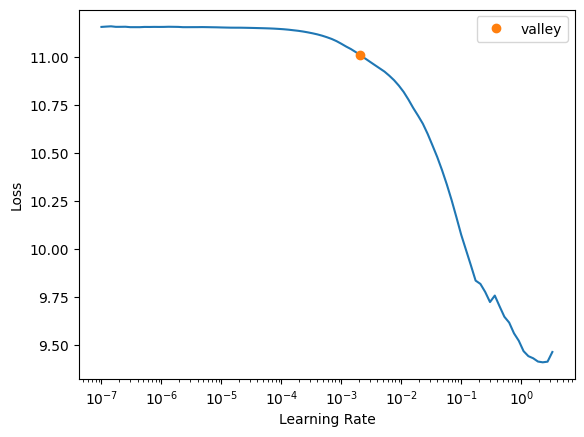

In [ ]:
# find the optimal learning rate
learn.lr_find()

Ok, now let's fit the model.

In [ ]:
# train the language model
learn.fit_one_cycle(EPOCHS, 1e-2, wd=0.1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.167676,4.055808,0.320612,57.731796,17:53
1,3.927599,3.815722,0.343034,45.409542,18:10
2,3.839007,3.736024,0.352205,41.930946,18:11


Finally, let's save the model.

In [ ]:
learn.save("custom_lstm")

Path('models/custom_lstm.pth')

### Finally let's evaluate our language model:

The evaluation of a text generation task can be subjective and depend on the specific goals of the task. However, there are several common methods that can be used to evaluate the quality of the generated text.

1. __Human evaluation:__ One of the most reliable methods for evaluating text generation is through human evaluation. This involves having human evaluators read the generated text and rate its quality based on various metrics such as coherence, fluency, and relevance to the prompt or topic. This method provides a subjective evaluation of the text and can give insights into how well the generated text matches human writing.

2. __Automated metrics:__ Automated metrics can be used to evaluate text generation based on various quantitative measures. Examples of automated metrics include perplexity, BLEU score, and ROUGE score. These metrics compare the generated text to a reference text or corpus, and provide a measure of the similarity between the two texts.

3. __Domain-specific metrics:__ For text generation tasks that are focused on a specific domain, such as medical or legal writing, domain-specific metrics can be used to evaluate the quality of the generated text. These metrics are designed to measure the accuracy and completeness of the generated text within the specific domain.

4. __User testing:__ In some cases, user testing can be used to evaluate the quality of the generated text. This involves having users interact with the generated text and providing feedback on its quality, usefulness, and relevance to the task or topic.


__Perplexity__

In [ ]:
valid_perplexity = learn.validate()[2]

In [ ]:
valid_perplexity

42.068634033203125